# ECE9039 MACHINE LEARNING 

## Data Preprocessing

In [2]:
import tensorflow as tf
import numpy as np
import os
from PIL import Image
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization, Activation, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam
from collections import Counter
from sklearn.utils import shuffle
from PIL import Image, ImageOps
from sklearn.metrics import accuracy_score
import random
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, LearningRateScheduler
from tensorflow.keras.models import load_model
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_val_score
import tensorflow as tf
from tensorflow.keras.layers import Input, Conv2D, ReLU, BatchNormalization, Flatten, Dense, Reshape, Conv2DTranspose, Activation
from tensorflow.keras.models import Model
from tensorflow.keras import layers

In [4]:
gpus = tf.config.list_physical_devices('GPU')

if gpus:
    print(f"Num GPUs Available: {len(gpus)}")
    for gpu in gpus:
        print("Name:", gpu.name, "Type:", gpu.device_type)
else:
    print("No GPU is available.")

Num GPUs Available: 1
Name: /physical_device:GPU:0 Type: GPU


### Load dataset

In [3]:
def load_images_and_labels(dataset_path, target_size=(224, 224)):
    images = []
    labels = []
    
    # Loop through each subfolder in the dataset directory
    for root, dirs, files in os.walk(dataset_path):
        if root == dataset_path:
            continue
        label = os.path.basename(root)
        count = 0
        for file in sorted(files):
            if file.lower().endswith(".jpg"):
                # Construct the full path to the image file
                file_path = os.path.join(root, file)
                image = Image.open(file_path).convert('RGB').resize(target_size)
                images.append(np.array(image))
                labels.append(label)
                count += 1
                
    return np.array(images), np.array(labels)

In [4]:
dataset_path = 'RealWaste/'
images, labels = load_images_and_labels(dataset_path)

print("Images shape:", images.shape)
print("Labels count:", len(np.unique(labels)))

Images shape: (4752, 224, 224, 3)
Labels count: 9


In [5]:
indices = np.arange(images.shape[0])
np.random.shuffle(indices)
images = images[indices]
labels = labels[indices]

In [6]:
label_counts = Counter(labels)
for label, count in label_counts.items():
    print(f"{label}: {count}")

Food Organics: 411
Paper: 500
Plastic: 921
Cardboard: 461
Vegetation: 436
Textile Trash: 318
Metal: 790
Glass: 420
Miscellaneous Trash: 495


### Isolate test set

In [7]:
num_of_test_samples_per_class = 100
target_num_of_train_per_class = 800

In [8]:
classes = np.unique(labels)
test_indices = []
train_indices = []

for class_label in classes:
    # Find the indices of images belonging to the current class
    class_indices = np.where(labels == class_label)[0]
    
    # Shuffle the indices to ensure random selection
    np.random.shuffle(class_indices)
    test_indices.extend(class_indices[:num_of_test_samples_per_class])
    train_indices.extend(class_indices[num_of_test_samples_per_class:])

test_images = images[test_indices]
test_labels = labels[test_indices]
train_images = images[train_indices]
train_labels = labels[train_indices]

In [9]:
print(train_images.shape)
print(train_labels.shape)

(3852, 224, 224, 3)
(3852,)


In [10]:
images = None
labels = None

In [11]:
label_counts = Counter(train_labels)
for label, count in label_counts.items():
    print(f"{label}: {count}")

Cardboard: 361
Food Organics: 311
Glass: 320
Metal: 690
Miscellaneous Trash: 395
Paper: 400
Plastic: 821
Textile Trash: 218
Vegetation: 336


### Data augmentation

In [12]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [13]:
dict = {}
for i in label_counts:
    desired = target_num_of_train_per_class-label_counts[i]
    dict[i] = desired if desired > 0 else 0

In [14]:
print(dict)
print(sum(dict.values()))

{'Cardboard': 439, 'Food Organics': 489, 'Glass': 480, 'Metal': 110, 'Miscellaneous Trash': 405, 'Paper': 400, 'Plastic': 0, 'Textile Trash': 582, 'Vegetation': 464}
3369


In [15]:
datagen = ImageDataGenerator(
    rotation_range=30,
    width_shift_range=0.1,
    height_shift_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True,
    fill_mode='nearest'
)

In [16]:
augmented_images = []
augmented_labels = []

def generate_augmented_image(image, label): #,index
    for x_batch in datagen.flow(image.reshape((1,)+image.shape),batch_size=1): # ,save_to_dir='Preview', save_prefix=str(index), save_format='jpg'
        augmented_images.append(x_batch[0])
        augmented_labels.append(label)
        break


In [17]:
i = 0
while sum(dict.values()) > 0:
    j = i % len(train_images)
    if dict[train_labels[j]] > 0:
        dict[train_labels[j]]-=1 
        generate_augmented_image(train_images[j],train_labels[j])
    i+=1

In [18]:
print(np.array(augmented_images).shape)
print(np.array(augmented_labels).shape)

(3369, 224, 224, 3)
(3369,)


In [19]:
train_aug_images = np.concatenate((train_images,augmented_images))
train_aug_labels = np.concatenate((train_labels,augmented_labels))

In [20]:
print(train_aug_images.shape)
print(train_aug_labels.shape)
print(test_images.shape)
print(test_labels.shape)

(7221, 224, 224, 3)
(7221,)
(900, 224, 224, 3)
(900,)


In [21]:
label_counts = Counter(train_aug_labels)
for label, count in label_counts.items():
    print(f"{label}: {count}")

Cardboard: 800
Food Organics: 800
Glass: 800
Metal: 800
Miscellaneous Trash: 800
Paper: 800
Plastic: 821
Textile Trash: 800
Vegetation: 800


In [22]:
label_encoder = LabelEncoder()
train_aug_labels_encoded = label_encoder.fit_transform(train_aug_labels)
test_labels_encoded = label_encoder.transform(test_labels)

In [23]:
X_train = train_aug_images
y_train = train_aug_labels_encoded

X_val, X_test, y_val, y_test = train_test_split(test_images, test_labels_encoded, test_size=0.5, random_state=42)

print(X_train.shape)
print(y_train.shape)
print(X_val.shape)
print(y_val.shape)
print(X_test.shape)
print(y_test.shape)

(7221, 224, 224, 3)
(7221,)
(450, 224, 224, 3)
(450,)
(450, 224, 224, 3)
(450,)


In [40]:
train_aug_images = None
train_aug_labels = None
train_aug_labels_encoded = None
#test_images = None
#test_labels = None
#test_labels_encoded = None

## Feature Extraction Methods

### SIFT

In [25]:
import cv2

In [23]:
print(train_images.shape)
print(train_labels.shape)
print(test_images.shape)
print(test_labels.shape)

(3852, 224, 224, 3)
(3852,)
(900, 224, 224, 3)
(900,)


In [27]:
def extract_sift_features(images, labels, num_strongest=50):
    sift = cv2.SIFT_create(num_strongest)
    features = []
    new_labels = []
    
    i = 0
    for i in range(len(images)):
        gray = cv2.cvtColor(images[i], cv2.COLOR_RGB2GRAY)
        pts, des = sift.detectAndCompute(gray, None)
        j = 0
        for j in range(num_strongest):
            new_labels.append(labels[i])
            if j < len(des):
                features.append(np.array(des[j]))
            else:
                features.append(np.zeros((128,)))
        
    return np.array(features),np.array(new_labels)

In [28]:
def extract_sift_features2(images):
    # Initialize SIFT detector and select strongest 50
    sift = cv2.SIFT_create(50)
    features = []
    
    for img in images:
        gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
        # Detect SIFT features and compute descriptors
        pts, des = sift.detectAndCompute(gray, None)
        if des is not None:
            # Simple feature aggregation by taking the mean
            des_mean = np.mean(des, axis=0)
        else:
            # If no features are found, use a zero vector
            des_mean = np.zeros((128,))
        features.append(des_mean)
        
    return np.array(features)

In [29]:
train_labels_encoded = label_encoder.fit_transform(train_labels)

In [30]:
#X_train_des, y_train_des = extract_sift_features(train_images, train_labels_encoded)
#test_features, test_featured_labels = extract_sift_features(test_images, test_labels_encoded)
#X_val_des, X_test_des, y_val_des, y_test_des = train_test_split(test_features, test_featured_labels, test_size=0.5, random_state=42)

In [31]:
X_train_des = extract_sift_features2(train_images)
y_train_des = train_labels_encoded
test_features = extract_sift_features2(test_images)
X_val_des, X_test_des, y_val_des, y_test_des = train_test_split(test_features, test_labels_encoded, test_size=0.5, random_state=42)

In [32]:
print(X_train_des.shape)
print(y_train_des.shape)

(3852, 128)
(3852,)


In [33]:
print(X_val_des.shape)
print(y_val_des.shape)
print(X_test_des.shape)
print(y_test_des.shape)

(450, 128)
(450,)
(450, 128)
(450,)


## Autoencoder

In [24]:
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(7221, 224, 224, 3)
(7221,)
(450, 224, 224, 3)
(450,)


In [53]:
from tensorflow.keras.layers import UpSampling2D
input_img = Input(shape=(224,224,3))

x = Conv2D(16, (3, 3), activation='relu', padding='same')(input_img)
x = MaxPooling2D((2, 2), padding='same')(x)
x = Conv2D(8, (3, 3), activation='relu', padding='same')(x)
x = MaxPooling2D((2, 2), padding='same')(x)
x = Conv2D(8, (3, 3), activation='relu', padding='same')(x)
encoded = MaxPooling2D((2, 2), padding='same')(x)


x = Conv2D(8, (3, 3), activation='relu', padding='same')(encoded)
x = UpSampling2D((2, 2))(x)
x = Conv2D(8, (3, 3), activation='relu', padding='same')(x)
x = UpSampling2D((2, 2))(x)
x = Conv2D(16, (3, 3), activation='relu', padding='same')(x)
x = UpSampling2D((2, 2))(x)
decoded = Conv2D(3, (3, 3), activation='linear', padding='same')(x)

autoencoder = Model(input_img, decoded)
autoencoder.compile(optimizer='adam', loss='binary_crossentropy')

autoencoder.summary()

Model: "model_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_8 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 conv2d_18 (Conv2D)          (None, 224, 224, 16)      448       
                                                                 
 max_pooling2d_9 (MaxPooling  (None, 112, 112, 16)     0         
 2D)                                                             
                                                                 
 conv2d_19 (Conv2D)          (None, 112, 112, 8)       1160      
                                                                 
 max_pooling2d_10 (MaxPoolin  (None, 56, 56, 8)        0         
 g2D)                                                            
                                                                 
 conv2d_20 (Conv2D)          (None, 56, 56, 8)         584 

In [54]:
print(X_train.shape)
print(X_test.shape)

(7221, 224, 224, 3)
(450, 224, 224, 3)


In [56]:
autoencoder.fit(X_train, X_train, epochs=20, batch_size=32, shuffle=True, validation_data=(X_test, X_test))

Epoch 1/20
226/226 [==============================] - 57s 254ms/step - loss: 0.6146 - val_loss: 0.6149
Epoch 2/20
226/226 [==============================] - 57s 254ms/step - loss: 0.6115 - val_loss: 0.6108
Epoch 3/20
226/226 [==============================] - 57s 251ms/step - loss: 0.6086 - val_loss: 0.6098
Epoch 4/20
226/226 [==============================] - 56s 249ms/step - loss: 0.6089 - val_loss: 0.6096
Epoch 5/20
226/226 [==============================] - 57s 254ms/step - loss: 0.6075 - val_loss: 0.6089
Epoch 6/20
226/226 [==============================] - 56s 249ms/step - loss: 0.6072 - val_loss: 0.6087
Epoch 7/20
226/226 [==============================] - 57s 250ms/step - loss: 0.6071 - val_loss: 0.6086
Epoch 8/20
226/226 [==============================] - 57s 252ms/step - loss: 0.6069 - val_loss: 0.6084
Epoch 9/20
226/226 [==============================] - 57s 251ms/step - loss: 0.6073 - val_loss: 0.6083
Epoch 10/20
226/226 [==============================] - 57s 253ms/step - l

In [57]:
encoder = Model(input_img, encoded)
encoded_imgs_train = encoder.predict(X_train)
encoded_imgs_test = encoder.predict(X_test)


15/15 [==============================] - 0s 29ms/step


In [60]:
X_train_encoded = encoded_imgs_train
X_test_encoded = encoded_imgs_test

In [68]:
from tensorflow.keras.utils import to_categorical
y_train_encoded = to_categorical(y_train, num_classes=9)
y_test_encoded = to_categorical(y_test, num_classes=9)

In [71]:
print(X_train_encoded.shape)
print(X_test_encoded.shape)
print(y_train_encoded.shape)
print(y_test_encoded.shape)

(7221, 28, 28, 8)
(450, 28, 28, 8)
(7221, 9)
(450, 9)


### CNN Model Using Autoencoder Features

In [95]:
def plot_cost_function(history):
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()
    plt.figure(figsize=(8, 5))
    plt.plot(history.history['accuracy'], label='Training Accuracy', marker='o')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy', marker='o')
    plt.ylim(0.4, 1.0)
    # Add labels and title
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.title('Training Accuracy')
    plt.legend()


In [91]:
from tensorflow.keras import layers, models, regularizers, optimizers
cnn_model = models.Sequential([
    layers.Conv2D(32, (3, 3), activation='relu', padding='same',
                  input_shape=encoded_imgs_train.shape[1:]),
    layers.BatchNormalization(),
    layers.MaxPooling2D((2, 2)),
    layers.Dropout(0.3),

    layers.Conv2D(64, (3, 3), activation='relu', padding='same'),
    layers.BatchNormalization(),
    layers.MaxPooling2D((2, 2)),
    layers.Dropout(0.3),

    layers.Conv2D(128, (3, 3), activation='relu', padding='same'),
    layers.BatchNormalization(),
    layers.MaxPooling2D((2, 2)),
    layers.Dropout(0.4),

    layers.Flatten(),
    layers.Dense(128, activation='relu', kernel_regularizer=regularizers.l2(0.01)),
    layers.Dropout(0.5),
    layers.Dense(9, activation='softmax')
])

optimizer = optimizers.Adam(learning_rate=0.001)
cnn_model.compile(optimizer=optimizer,
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])

early_stopping = callbacks.EarlyStopping(monitor='val_accuracy', patience=10, restore_best_weights=True)
reduce_lr = callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=0.0001)

history = cnn_model.fit(encoded_imgs_train, y_train_encoded,
                        epochs=100,
                        batch_size=32,
                        validation_data=(encoded_imgs_test, y_test_encoded),
                        callbacks=[early_stopping, reduce_lr])


Epoch 1/100
226/226 [==============================] - 4s 13ms/step - loss: 3.9254 - accuracy: 0.2844 - val_loss: 10.9562 - val_accuracy: 0.1089 - lr: 0.0010
Epoch 2/100
226/226 [==============================] - 3s 13ms/step - loss: 2.6807 - accuracy: 0.3941 - val_loss: 3.4343 - val_accuracy: 0.2933 - lr: 0.0010
Epoch 3/100
226/226 [==============================] - 3s 12ms/step - loss: 2.0929 - accuracy: 0.4602 - val_loss: 2.2875 - val_accuracy: 0.4200 - lr: 0.0010
Epoch 4/100
226/226 [==============================] - 3s 12ms/step - loss: 1.7809 - accuracy: 0.5048 - val_loss: 2.5718 - val_accuracy: 0.3444 - lr: 0.0010
Epoch 5/100
226/226 [==============================] - 3s 12ms/step - loss: 1.6121 - accuracy: 0.5402 - val_loss: 1.6443 - val_accuracy: 0.5244 - lr: 0.0010
Epoch 6/100
226/226 [==============================] - 3s 12ms/step - loss: 1.5426 - accuracy: 0.5537 - val_loss: 2.0446 - val_accuracy: 0.4267 - lr: 0.0010
Epoch 7/100
226/226 [==============================] - 3s

In [97]:
cnn_test_loss, cnn_test_accuracy = cnn_model.evaluate(encoded_imgs_test, y_test_encoded)
print(f"CNN Test accuracy: {cnn_test_accuracy:.4f}")

15/15 [==============================] - 0s 4ms/step - loss: 0.7434 - accuracy: 0.7889
CNN Test accuracy: 0.7889


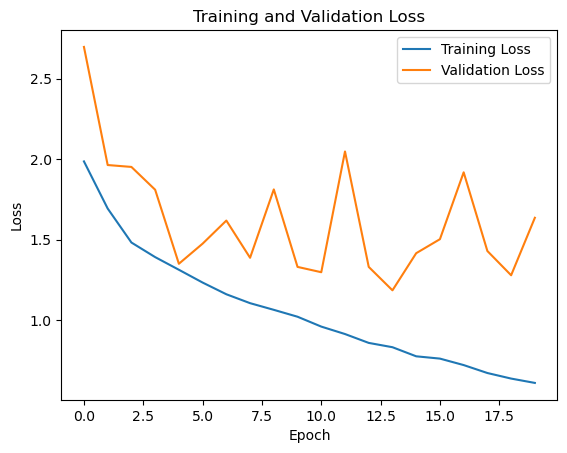

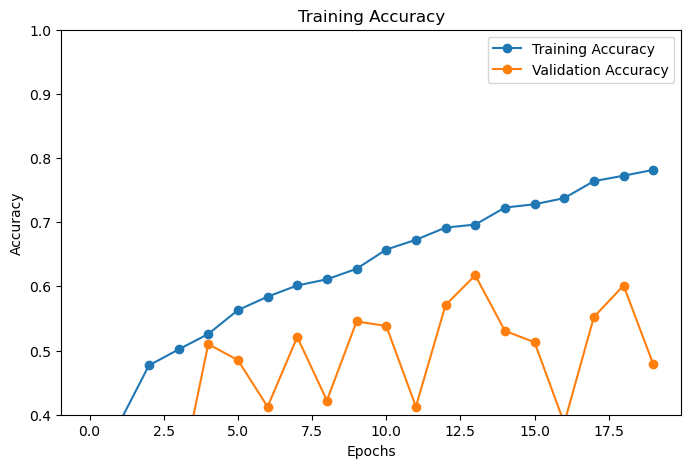

In [96]:
plot_cost_function(cnn_history)

## Dimensionality Reduction Methods

### PCA

scaler = StandardScaler()
X_train_des = scaler.fit_transform(X_train_des)
X_test_des = scaler.fit_transform(X_test_des)

pca = PCA(n_components=64)
X_train_des = pca.fit_transform(X_train_des)
X_test_des = pca.fit_transform(X_test_des)

## Models use feature descriptors

### Random Forests

In [75]:
from sklearn.ensemble import RandomForestClassifier
from hyperopt import hp, fmin, tpe, STATUS_OK, Trials
from ray import train
from ray.tune.schedulers import HyperBandScheduler

In [90]:
def train_random_forest(config):    
    model = RandomForestClassifier(n_estimators=config["n_estimators"], max_depth=config["max_depth"])
    model.fit(X_train_des, y_train_des)
    preds = model.predict(X_test_des)
    accuracy = accuracy_score(y_test_des, preds)
    
    train.report({'accuracy': accuracy})

In [91]:
config = {
    "n_estimators": tune.choice([10, 50, 100, 300, 500, 700]),
    "max_depth": tune.choice([5, 10, 20, 30, 40, 50]),
}

scheduler = HyperBandScheduler(metric="accuracy", mode="max")

In [92]:
analysis = tune.run(
    train_random_forest,
    config=config,
    num_samples=10,
    scheduler=scheduler,
    resources_per_trial={"cpu": 1, "gpu": 1},
)

2024-03-05 11:29:11,880	INFO tune.py:646 -- [output] This uses the legacy output and progress reporter, as Jupyter notebooks are not supported by the new engine, yet. For more information, please see https://github.com/ray-project/ray/issues/36949


Trial name,accuracy
train_random_forest_7fb8c_00000,0.262222
train_random_forest_7fb8c_00001,0.237778
train_random_forest_7fb8c_00002,0.32
train_random_forest_7fb8c_00003,0.333333
train_random_forest_7fb8c_00004,0.253333
train_random_forest_7fb8c_00005,0.311111
train_random_forest_7fb8c_00006,0.322222
train_random_forest_7fb8c_00007,0.291111
train_random_forest_7fb8c_00008,0.244444
train_random_forest_7fb8c_00009,0.257778


2024-03-05 11:30:45,433	INFO tune.py:1144 -- Total run time: 93.55 seconds (93.53 seconds for the tuning loop).


### SVM

In [36]:
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler

In [37]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_des)
X_test_scaled = scaler.transform(X_test_des)
svm_model = SVC(kernel='linear')
svm_model.fit(X_train_scaled, y_train_des)
y_pred = svm_model.predict(X_test_scaled)
accuracy = accuracy_score(y_test_des, y_pred)
print(f"SVM Classification Accuracy: {accuracy}")

SVM Classification Accuracy: 0.38222222222222224


## Models use raw image

In [1]:
def loss_plot(history):
    plt.figure(figsize=(10, 5))
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Loss function Plot')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(loc='upper right')
    plt.grid(True)
    plt.show()

### Transfer learning

In [25]:
def step_decay(epoch, lr):
    drop = 0.5
    epochs_drop = 10.0
    return lr * (drop ** (epoch // epochs_drop))

In [26]:
def train_with_pretrained_model(X_train_t,y_train_t,X_val_t,y_val_t,base_model,filename,initial_lr):
    base_model.trainable = True
    model = Sequential([
        base_model,
        GlobalAveragePooling2D(),
        #Dense(512, activation='relu'),
        Dense(9, activation='softmax')
    ])

    lr_scheduler = LearningRateScheduler(step_decay)
    early_stopping = EarlyStopping(monitor='val_loss', patience=15, verbose=1, mode='min')
    model_checkpoint = ModelCheckpoint(filepath=filename, monitor='val_accuracy', save_best_only=True, verbose=1)

    model.compile(optimizer=Adam(learning_rate=initial_lr), loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    history = model.fit(X_train_t, y_train_t, epochs=50,validation_data=(X_val_t, y_val_t), batch_size=32, callbacks=[lr_scheduler, early_stopping, model_checkpoint])
    return model,history    

#### VGG19

In [26]:
from tensorflow.keras.applications import VGG19

In [27]:
[VGG19_model, VGG19_history] = train_with_pretrained_model(X_train, y_train, X_val, y_val, VGG19(include_top=False, weights='imagenet', input_shape=(224,224,3)), "VGG19_t.h5", 0.0001)
loss, accuracy = VGG19_model.evaluate(X_test, y_test)
print(f'Test loss: {loss}, Test accuracy: {accuracy}')

Epoch 1/50
226/226 [==============================] - 49s 177ms/step - loss: 2.0660 - accuracy: 0.2227 - val_loss: 1.6954 - val_accuracy: 0.3778

Epoch 00001: val_accuracy improved from -inf to 0.37778, saving model to VGG19_t.h5
Epoch 2/50
226/226 [==============================] - 37s 164ms/step - loss: 1.5748 - accuracy: 0.4210 - val_loss: 1.2931 - val_accuracy: 0.5267

Epoch 00002: val_accuracy improved from 0.37778 to 0.52667, saving model to VGG19_t.h5
Epoch 3/50
226/226 [==============================] - 38s 169ms/step - loss: 1.2350 - accuracy: 0.5358 - val_loss: 1.2288 - val_accuracy: 0.5489

Epoch 00003: val_accuracy improved from 0.52667 to 0.54889, saving model to VGG19_t.h5
Epoch 4/50
226/226 [==============================] - 38s 167ms/step - loss: 1.0592 - accuracy: 0.5959 - val_loss: 1.0370 - val_accuracy: 0.6333

Epoch 00004: val_accuracy improved from 0.54889 to 0.63333, saving model to VGG19_t.h5
Epoch 5/50
226/226 [==============================] - 38s 170ms/step - 

#### DenseNet121

In [27]:
from tensorflow.keras.applications import DenseNet121

In [28]:
[DenseNet121_model, DenseNet121_history] = train_with_pretrained_model(X_train, y_train, X_val, y_val, DenseNet121(include_top=False, weights='imagenet', input_shape=(224,224,3)), "DenseNet121_t.h5", 0.001)
loss, accuracy = DenseNet121_model.evaluate(X_test, y_test)
print(f'Test loss: {loss}, Test accuracy: {accuracy}')

Epoch 1/50
226/226 [==============================] - 48s 153ms/step - loss: 0.8595 - accuracy: 0.7092 - val_loss: 1.7597 - val_accuracy: 0.5244

Epoch 00001: val_accuracy improved from -inf to 0.52444, saving model to DenseNet121_t.h5
Epoch 2/50
226/226 [==============================] - 30s 134ms/step - loss: 0.4650 - accuracy: 0.8384 - val_loss: 2.1223 - val_accuracy: 0.3756

Epoch 00002: val_accuracy did not improve from 0.52444
Epoch 3/50
226/226 [==============================] - 29s 128ms/step - loss: 0.3474 - accuracy: 0.8755 - val_loss: 1.7762 - val_accuracy: 0.5533

Epoch 00003: val_accuracy improved from 0.52444 to 0.55333, saving model to DenseNet121_t.h5
Epoch 4/50
226/226 [==============================] - 31s 137ms/step - loss: 0.2445 - accuracy: 0.9139 - val_loss: 1.3933 - val_accuracy: 0.6489

Epoch 00004: val_accuracy improved from 0.55333 to 0.64889, saving model to DenseNet121_t.h5
Epoch 5/50
226/226 [==============================] - 31s 136ms/step - loss: 0.2657 -

#### InceptionV3

In [26]:
from tensorflow.keras.applications import InceptionV3

In [27]:
[InceptionV3_model, InceptionV3_history] = train_with_pretrained_model(X_train, y_train, X_val, y_val, InceptionV3(include_top=False, weights='imagenet', input_shape=(224,224,3)), "InceptionV3_t.h5", 0.001)
loss, accuracy = InceptionV3_model.evaluate(X_test, y_test)
print(f'Test loss: {loss}, Test accuracy: {accuracy}')

87916544/87910968 [==============================] - 16s 0us/step
Epoch 1/50
226/226 [==============================] - 31s 98ms/step - loss: 0.9789 - accuracy: 0.6639 - val_loss: 2.8952 - val_accuracy: 0.3267

Epoch 00001: val_accuracy improved from -inf to 0.32667, saving model to EfficientNetB7_t.h5
Epoch 2/50
226/226 [==============================] - 20s 87ms/step - loss: 0.5936 - accuracy: 0.7948 - val_loss: 1.5709 - val_accuracy: 0.5267

Epoch 00002: val_accuracy improved from 0.32667 to 0.52667, saving model to EfficientNetB7_t.h5
Epoch 3/50
226/226 [==============================] - 19s 84ms/step - loss: 0.4476 - accuracy: 0.8445 - val_loss: 1.6033 - val_accuracy: 0.6000

Epoch 00003: val_accuracy improved from 0.52667 to 0.60000, saving model to EfficientNetB7_t.h5
Epoch 4/50
226/226 [==============================] - 19s 85ms/step - loss: 0.3354 - accuracy: 0.8813 - val_loss: 1.1666 - val_accuracy: 0.7000

Epoch 00004: val_accuracy improved from 0.60000 to 0.70000, saving mo

#### MobileNet

In [28]:
from tensorflow.keras.applications import MobileNet

In [29]:
[MobileNet_model, MobileNet_history] = train_with_pretrained_model(X_train, y_train, X_val, y_val, MobileNet(include_top=False, weights='imagenet', input_shape=(224,224,3)), "MobileNet_t.h5", 0.001)
loss, accuracy = MobileNet_model.evaluate(X_test, y_test)
print(f'Test loss: {loss}, Test accuracy: {accuracy}')

17227776/17225924 [==============================] - 13s 1us/step
Epoch 1/50
226/226 [==============================] - 24s 84ms/step - loss: 0.7436 - accuracy: 0.7567 - val_loss: 3.4404 - val_accuracy: 0.4378

Epoch 00001: val_accuracy improved from -inf to 0.43778, saving model to MobileNet_t.h5
Epoch 2/50
226/226 [==============================] - 18s 82ms/step - loss: 0.2858 - accuracy: 0.9015 - val_loss: 1.1461 - val_accuracy: 0.7044

Epoch 00002: val_accuracy improved from 0.43778 to 0.70444, saving model to MobileNet_t.h5
Epoch 3/50
226/226 [==============================] - 19s 82ms/step - loss: 0.2044 - accuracy: 0.9313 - val_loss: 1.0431 - val_accuracy: 0.7333

Epoch 00003: val_accuracy improved from 0.70444 to 0.73333, saving model to MobileNet_t.h5
Epoch 4/50
226/226 [==============================] - 19s 83ms/step - loss: 0.1897 - accuracy: 0.9331 - val_loss: 1.1143 - val_accuracy: 0.7533

Epoch 00004: val_accuracy improved from 0.73333 to 0.75333, saving model to MobileNe

### Ensemble (soft voting)

In [56]:
def voting(list_of_models, X_test_t, y_test_t):
    true = 0
    false = 0
    for i in range(len(X_test_t)):
        probs = []
        for model in list_of_models:
            img = np.expand_dims(X_test_t[i], axis=0)
            res = model.predict(img)
            probs.append(res)
        average_probs = np.mean(np.stack(probs), axis=0)
        decision = np.argmax(average_probs, axis=1)
        #print(decision)
        if decision == y_test_t[i]:
            true += 1
        else:
            false += 1      
    print("Correct predication:" ,true)
    print("Incorrect predication:" ,false)
    return true / (true + false)  

In [6]:
VGG19_model = load_model("VGG19_t.h5")
DenseNet121_model = load_model("DenseNet121_t.h5")
InceptionV3_model = load_model("InceptionV3_t.h5")
MobileNet_model = load_model("MobileNet_t.h5")

In [62]:
print(f"Test Accuracy: {voting([VGG19_model,DenseNet121_model,InceptionV3_model,MobileNet_model],X_test, y_test)}")

Correct predication: 450
Incorrect predication: 0
Test Accuracy: 1.0


In [7]:
def find_combinations(input_list, combination_lengths):
    from itertools import combinations
    
    all_combinations = []
    for length in combination_lengths:
        all_combinations.extend(list(combinations(input_list, length)))
    
    return all_combinations

In [14]:
input_list = [0, 1, 2, 3]
combination_lengths = [2]

resulting_combinations = find_combinations(input_list, combination_lengths)

In [15]:
model_list = [VGG19_model,DenseNet121_model,InceptionV3_model,MobileNet_model]

In [53]:
model_list1 = [VGG19_model,DenseNet121_model]

In [58]:
for (x,y) in resulting_combinations:
    print(f"Test Accuracy: {voting([model_list[x],model_list[y]],X_test, y_test)}")

Correct predication: 446
Incorrect predication: 4
Test Accuracy: 0.9911111111111112
Correct predication: 449
Incorrect predication: 1
Test Accuracy: 0.9977777777777778
Correct predication: 449
Incorrect predication: 1
Test Accuracy: 0.9977777777777778
Correct predication: 447
Incorrect predication: 3
Test Accuracy: 0.9933333333333333
Correct predication: 447
Incorrect predication: 3
Test Accuracy: 0.9933333333333333
Correct predication: 447
Incorrect predication: 3
Test Accuracy: 0.9933333333333333


In [60]:
combination_lengths = [3]
resulting_combinations = find_combinations(input_list, combination_lengths)

In [61]:
for (x,y,z) in resulting_combinations:
    print(f"Test Accuracy: {voting([model_list[x],model_list[y],model_list[z]],X_test, y_test)}")

Correct predication: 449
Incorrect predication: 1
Test Accuracy: 0.9977777777777778
Correct predication: 449
Incorrect predication: 1
Test Accuracy: 0.9977777777777778
Correct predication: 449
Incorrect predication: 1
Test Accuracy: 0.9977777777777778
Correct predication: 449
Incorrect predication: 1
Test Accuracy: 0.9977777777777778


In [59]:
for m in model_list:
    print(f"Test Accuracy: {voting([m],X_test, y_test)}")

Correct predication: 438
Incorrect predication: 12
Test Accuracy: 0.9733333333333334
Correct predication: 442
Incorrect predication: 8
Test Accuracy: 0.9822222222222222
Correct predication: 437
Incorrect predication: 13
Test Accuracy: 0.9711111111111111
Correct predication: 440
Incorrect predication: 10
Test Accuracy: 0.9777777777777777
